# Survival Analysis

Analyzing lung cancer patient data

## Load Data

In [33]:
%%capture output
!pip install lifelines;

In [65]:
from pandas import pandas
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [12]:
df = pd.read_csv('data/lung.csv')
df.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


# Clean Data

### Change status from 1 & 2 => 0, 1 (0: censored, 1: dead)

In [13]:
df.status.value_counts()

2    165
1     63
Name: status, dtype: int64

In [14]:
df.loc[df.status == 1, "status"] = 0
df.loc[df.status == 2, "status"] = 1
df.status.value_counts()

1    165
0     63
Name: status, dtype: int64

## Kaplan-Meir Estimator

Estimate the the survival function from the lifetime data
$$S(t_{i}) = S(t_{i-1})*(1-\frac{d_{i}}{n_{i}})$$

S(ti) = probability of survival at time t  
di = number of events at time t  
ni = number of survivors at time t  

In [21]:
model = KaplanMeierFitter()
model.fit(durations = df.time, event_observed=df.status)
model.event_table.head(4)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224


### Calculate for Specific Events

In [30]:
day_5 = model.event_table.iloc[1, :]
print(day_5)
surv_5 = 1*(1-day_5.observed / day_5.at_risk)
print(surv_5)

day_11 = model.event_table.iloc[2, :]
surv_11 = surv_5 * (1-day_11.observed / day_11.at_risk)
print(surv_11)

removed       1
observed      1
censored      0
entrance      0
at_risk     228
Name: 5.0, dtype: int64
0.9956140350877193
0.9824561403508771


### Approximation

In [31]:
surv_11_approx = (day_11.at_risk - day_11.observed) / day_11.at_risk
surv_11_approx

0.986784140969163

### Visualization

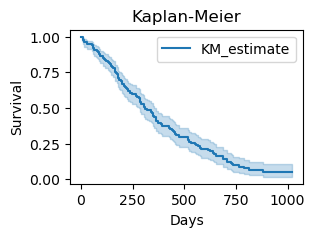

In [39]:
model.plot(figsize=(3,2))
plt.title('Kaplan-Meier')
plt.xlabel('Days')
plt.ylabel('Survival');

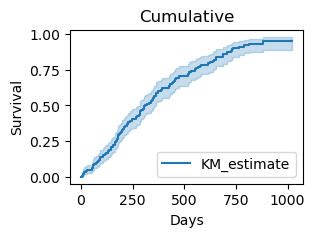

In [40]:
model.plot_cumulative_density(figsize=(3,2))
plt.title('Cumulative')
plt.xlabel('Days')
plt.ylabel('Survival');

### Analyze if difference between Males and Females Survivability

**Null Hypothesis**: There is no difference between both groups  

**If p-value > 0.05**: There is no difference between both groups

In [48]:
male_df = df.query('sex == 1')
male_df.sex.count()

138

In [49]:
female_df = df.query('sex == 2')
female_df.sex.count()

90

In [53]:
model_males = KaplanMeierFitter()
model_males.fit(durations=male_df.time, event_observed=male_df.status)
model_males.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,138,138
11.0,3,3,0,0,138
12.0,1,1,0,0,135
13.0,2,2,0,0,134
15.0,1,1,0,0,132


In [54]:
model_females = KaplanMeierFitter()
model_females.fit(durations=female_df.time, event_observed=female_df.status)
model_females.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,90,90
5.0,1,1,0,0,90
60.0,1,1,0,0,89
61.0,1,1,0,0,88
62.0,1,1,0,0,87


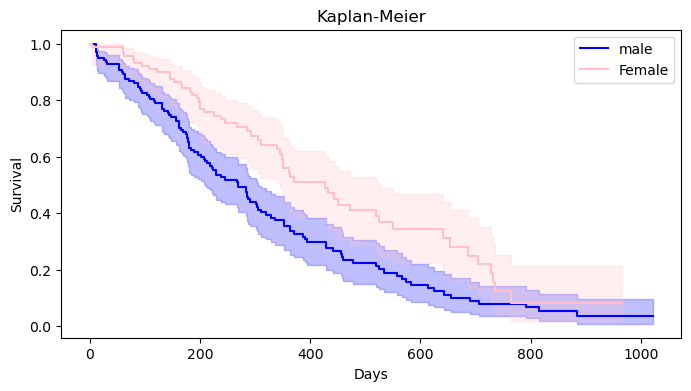

In [62]:
model_males.plot(figsize=(8,4), label="male", color='blue')
model_females.plot(label="Female", color='pink')
plt.title('Kaplan-Meier')
plt.xlabel('Days')
plt.ylabel('Survival');

### Log Rank Test

In [66]:
logrank_test(durations_A=male_df.time, durations_B=female_df.time, 
             event_observed_A=male_df.status, event_observed_B=female_df.status)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

### Conclusion:
Females have a higher survivability rate than males